In [1]:
import os
import math
import tarfile
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from sklearn.model_selection import train_test_split
import seaborn as sb
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

# Loading Data

In [2]:
housing_path = "F:/ML_Project/California_Housing/datasets/housing"

def load_data(housing_path = housing_path):
    try:
        csv_path = os.path.join(housing_path, "housing_california.csv")
        return pd.read_csv(csv_path)
    except FileNotFoundError:
        print("File not Found")
        
housing = load_data()

Information on table attributes:
* 13 columns and 16512 entries
* All columns are not null

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Data Visualization
hist matrix - seeing the frequency distribution of values in each attribute

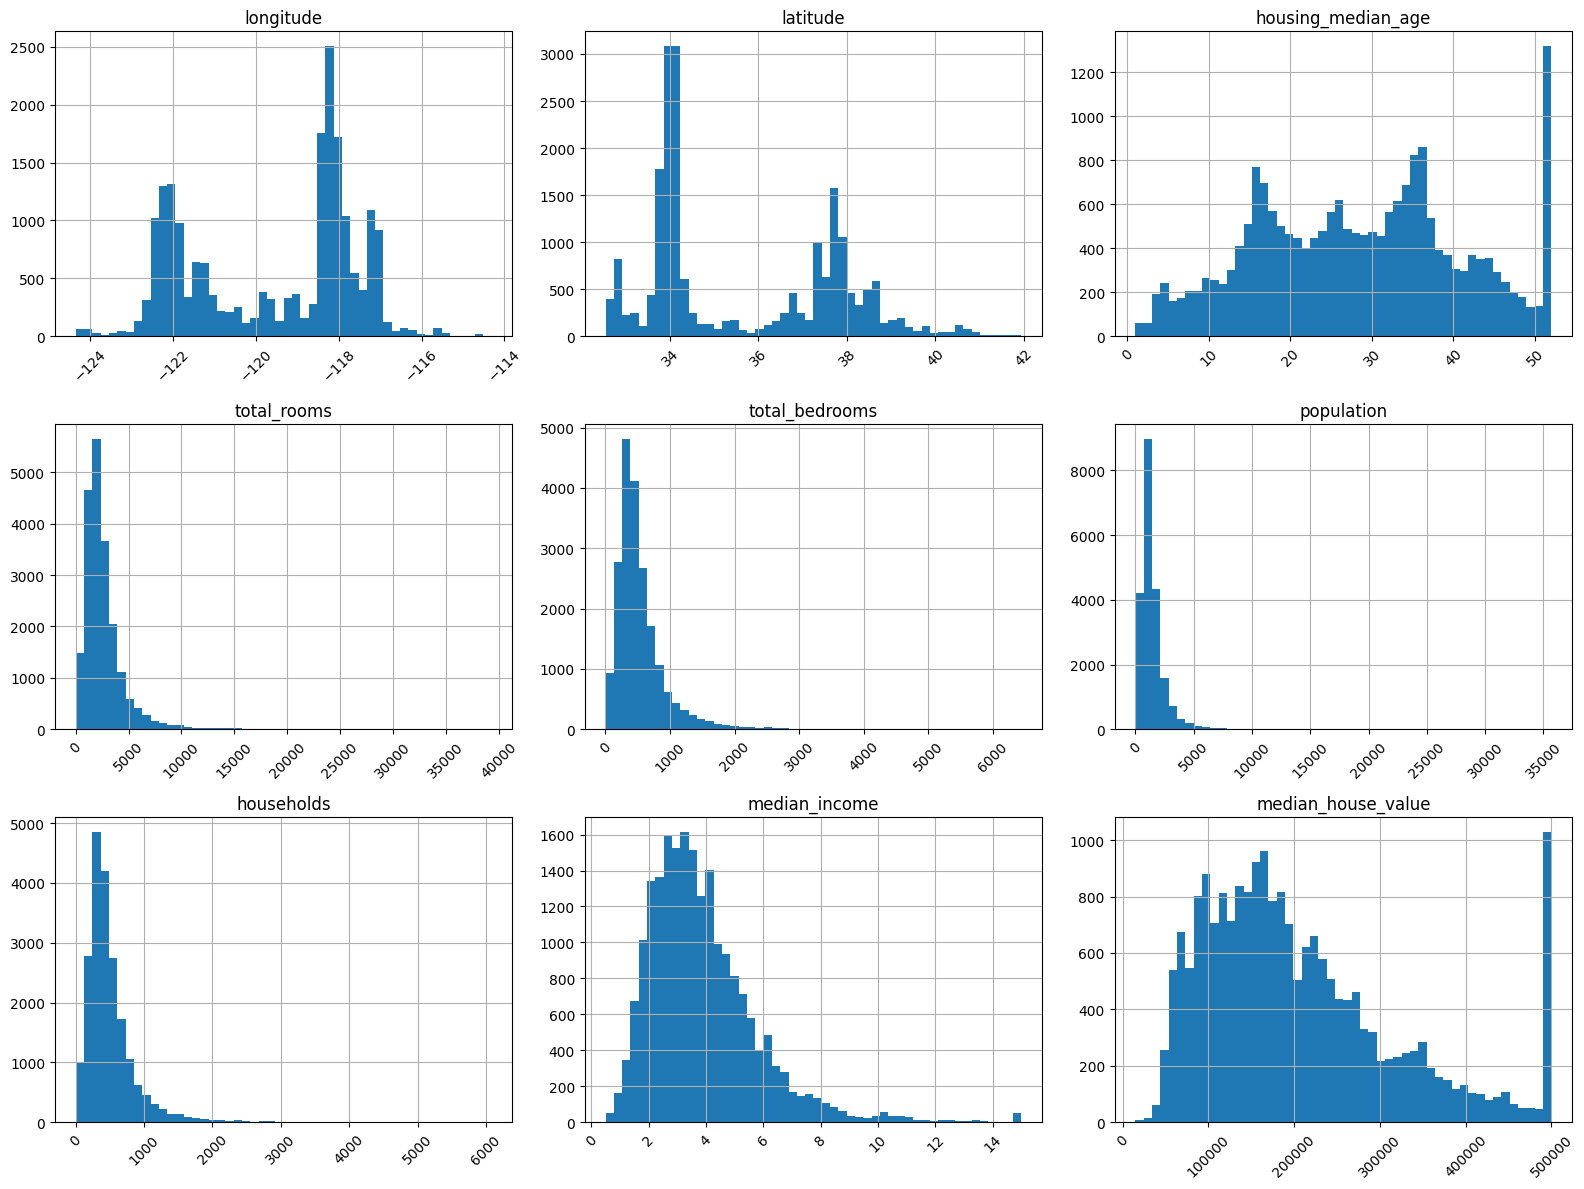

In [5]:
%matplotlib inline
#plt.hist(housing, bins=50, figsize = (12,10))
housing.hist(bins = 50, figsize = (16,12), xrot=45)
plt.tight_layout()
plt.show()

### Insights from Histogram
* ['median_income'] values are in normal bell shaped curved but it skew to expand at larger income levels
* ['households','total_rooms','total_bedrooms','population'] attributes are skewed to the right

# Train Test Split
Splitting the dataset into two parts: 
* one for training the model
* another for testing the model

In [6]:
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

In [7]:
train_set["median_income"].value_counts()

3.1250     42
15.0001    41
2.6250     39
4.1250     36
2.8750     35
           ..
2.6127      1
4.1165      1
5.7485      1
6.1527      1
2.5755      1
Name: median_income, Length: 10932, dtype: int64

### Stratified Sets are ones which are more effective in representing the proportion of population
for instance, if dataset consists of population where male and female are in ratio 6: 4, then the training and test split will also respresent the same proportions

<AxesSubplot: >

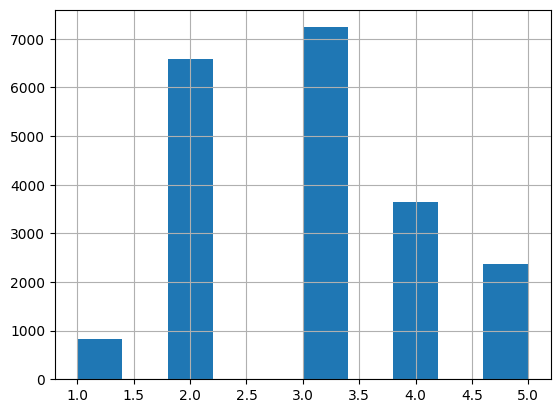

In [8]:
#Stratified Sets
housing["income_category"]=pd.cut(housing["median_income"], bins=[0,1.5,3.,4.5,6.,np.inf], labels=[1,2,3,4,5])
housing["income_category"].hist()

In [9]:
# Creating Stratified sets
Split = StratifiedShuffleSplit(n_splits=1, test_size= 0.2, random_state=42)
for train_index, test_index in Split.split(housing, housing["income_category"]):
    strat_train_set=housing.loc[train_index]
    strat_test_set=housing.loc[test_index]


In [10]:
# removing column from both sets
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_category", axis=1, inplace=True)

In [11]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


# Correlation
### change in one value with relation to another

In [12]:
data = strat_train_set.copy()
corr = data.corr(numeric_only=True)
corr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


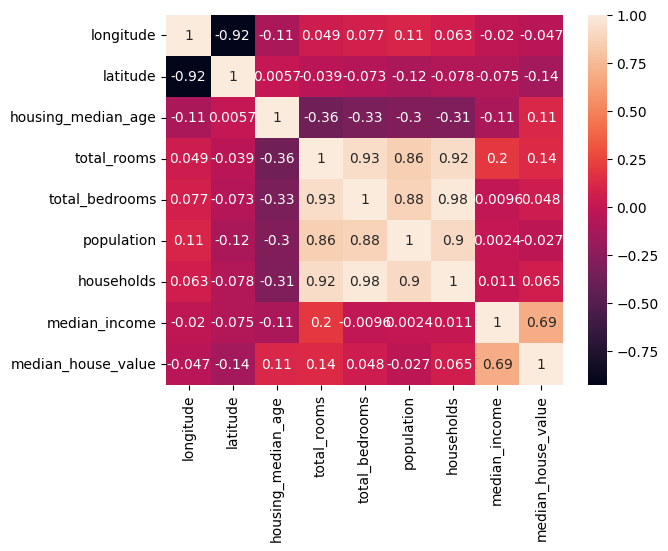

In [13]:
corr_matx = sb.heatmap(corr, cmap='rocket', annot = True)

### Adding useful columns
glipse of how transformation are made to construct new columns

In [14]:
housing = strat_train_set.copy()
housing["rooms_per_household"]=housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["populations_per_household"]=housing["population"]/housing["households"]

### Setting up Training estimator data and predict labels

In [15]:
housing = strat_train_set.drop("median_house_value", inplace = False, axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

### Setting numerical and categorical dataset

In [16]:
housing_cat = housing["ocean_proximity"].copy()
housing_num = housing.drop("ocean_proximity", inplace = False, axis = 1)

# Pipeline

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score as rs

### Preprocessing Steps

In [18]:
# transformer for adding neccessary columns like 'bedrooms per room'

rooms_ix, bedrooms_ix, population_ix, households_ix= 3,4,5,6 #attribute positions in data set

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix]/ X[:, households_ix]
        population_per_household = X[:, population_ix]/ X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedroom_per_room = X[:, bedrooms_ix]/ X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedroom_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs[1,:].shape

(11,)

### Pipelining tasks

In [19]:
# transformation for numerical columns using Pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

In [20]:
# selecting appropriate columns acc. to types
num_attribs = housing.select_dtypes(include = ['int64', 'float64']).columns
cat_attribs = ['ocean_proximity']

# merging columns after transformation
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

In [21]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


### Transformed Dataset

In [22]:
housing_prepared = preprocessor.fit_transform(housing)
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

# Select and Train Models

## 1. Linear Regression Model 

### - Final Pipeline

In [23]:
# All Pipeline Steps
# Using Linear Regression as model for prediction
pipe = Pipeline([('preprocessor', preprocessor),
                ('LR', LinearRegression())])

### - Fitting the Pipeline

In [24]:
# Fit
pipe.fit(housing, housing_labels)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  ['ocean_proximity'])])),
                ('LR', LinearRegression())])

In [25]:
y_pred = pipe.predict(housing)

In [26]:
linear_mse = mse(housing_labels, y_pred)
linear_rmse = np.sqrt(linear_mse)
print("mean squared error: ",linear_rmse)
print("cofficient of determination (close to 1 is better): ",rs(housing_labels,y_pred))

mean squared error:  68627.87390018745
cofficient of determination (close to 1 is better):  0.6481553634454353


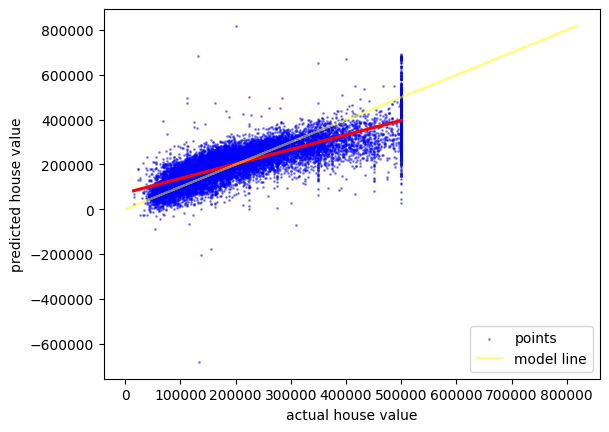

In [27]:
sb.regplot(y=y_pred,x= housing_labels, ci=None, color="red", 
           scatter_kws={"color":"blue",'s':1,'alpha':0.4}, label='points')

plt.plot(y_pred[y_pred > 0], y_pred[y_pred > 0], 'yellow', alpha=0.5, label='model line')
plt.xlabel("actual house value")
plt.ylabel("predicted house value")
plt.legend()
plt.show()

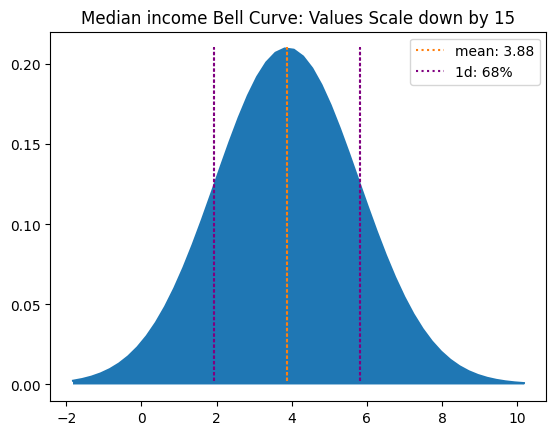

In [28]:
def fnc(x, mean, std):
    c = (x - mean)/sd
    #return (1/sd*math.sqrt(2*math.pi))*math.exp(-0.5*math.pow(c, 2))
    return 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))

sd = round(train_set['median_income'].std(), 2)
mean = round(train_set['median_income'].mean(), 2)

X = np.linspace(mean - 3*sd, mean - 3*sd + 12)
mean_X = np.ones(len(X))*mean
d1n = np.ones(len(X))*(mean/2)
d1p = np.ones(len(X))*(mean/2 + mean)
ans = [fnc(x,mean,sd) for x in X]
#spline = make_interp_spline(alist, ans) # making more curvy

plt.plot(X, ans)
plt.plot(mean_X,ans,linestyle =':',label = 'mean: %.2f' %(mean))
plt.plot(d1n,ans,':',color = 'purple', label = '1d: 68%')
plt.plot(d1p,ans,':',color = 'purple')
plt.fill_between(X, ans)
plt.legend()
plt.title("Median income Bell Curve: Values Scale down by 15")
plt.show()

## 2. Polynomial Regression

In [29]:
from sklearn.preprocessing import PolynomialFeatures

In [30]:
polynomial_regression = Pipeline([
            ("imputer", SimpleImputer(strategy='mean')),
            ('attribs_adder', CombinedAttributesAdder()),
            ("poly_features", PolynomialFeatures(degree=3)),
            ("std_scaler", StandardScaler()),
        ])

poly_preprocessor = ColumnTransformer([
    ("num_attr", polynomial_regression, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

poly_pipe = Pipeline([
    ("preprocessor", poly_preprocessor),
    ("linearRegr", LinearRegression())
])

In [31]:
poly_pipe.fit(housing, housing_labels)
y_pred_poly = poly_pipe.predict(housing)
print("r2 score: ",rs(housing_labels, y_pred_poly))

r2 score:  0.7630510231433456


In [32]:
poly_pipe.feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'], dtype=object)

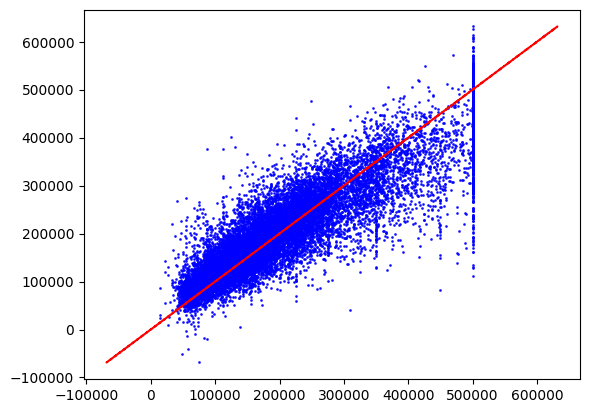

In [33]:
plt.scatter(x=housing_labels, y=y_pred_poly, c='b', s=1, alpha=0.8)
plt.plot(y_pred_poly, y_pred_poly, 'r--')
plt.show()

## 3. SVR (Support Vector Regressor)
[link to SVR blogpost](https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/)

In [34]:
from sklearn.svm import SVR

In [35]:
# Using SVR as model for prediction
pipe_svr = Pipeline([('preprocessor', preprocessor),
                ('SVR', SVR(kernel='rbf'))])
pipe_svr.fit(housing, housing_labels)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  ['ocean_proximity'])])),
                ('SVR', SVR())])

In [36]:
# svm_reg = SVR(kernel="linear")
# svm_reg.fit(housing_prepared, housing_labels)
# y_pred = svm_reg.predict(housing_prepared)
# svm_mse = mse(housing_labels, y_pred)
# svm_rmse = np.sqrt(svm_mse)
# svm_rmse

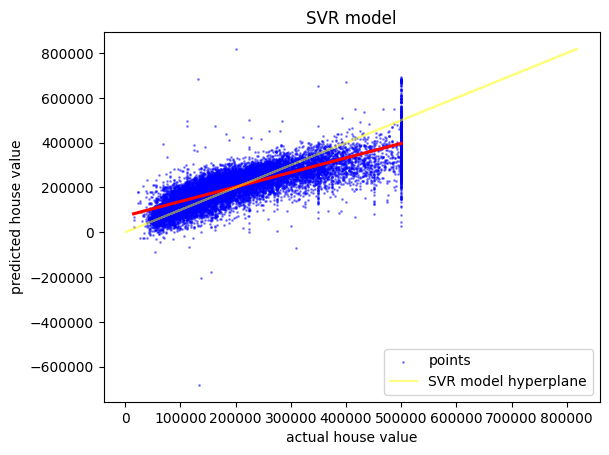

In [37]:
sb.regplot(y=y_pred,x= housing_labels, ci=None, color="red", 
           scatter_kws={"color":"blue",'s':1,'alpha':0.4}, label='points')

plt.plot(y_pred[y_pred > 0], y_pred[y_pred > 0], 'yellow', alpha=0.5, label='SVR model hyperplane')
plt.xlabel("actual house value")
plt.ylabel("predicted house value")
plt.title("SVR model")
plt.legend()
plt.show()

## Random Forest Regressor

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [39]:
rfr_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rfr_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [40]:
y_pred = rfr_reg.predict(housing_prepared)
print("mean absolute error: ", mse(housing_labels, y_pred, squared=False))
print("rs: ",rs(housing_labels, y_pred))

mean absolute error:  18650.698705770003
rs:  0.9740139626391636


In [ ]:
forest_scores = cross_val_score(rfr_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)

In [ ]:
pd.Series(np.sqrt(-forest_scores)).describe()

In [ ]:
pipe_rfr = Pipeline([
    ('preprocessor',preprocessor),
    ('RFR', RandomForestRegressor(n_estimators=100, random_state=42))
])
pipe_rfr.fit(housing, housing_labels)

In [ ]:
sb.regplot(y=y_pred,x= housing_labels, ci=None, color="red", 
           scatter_kws={"color":"grey",'s':1,'alpha':0.4}, label='points')

plt.plot(y_pred[y_pred > 0], y_pred[y_pred > 0], 'blue', alpha=0.9, label='RFR model')
plt.xlabel("actual house value")
plt.ylabel("predicted house value")
plt.title("RFR model")
plt.legend()
plt.show()

In [ ]:
# A test Case
X = housing.iloc[35,:]
y = housing_labels.loc[35]

y_test_lr = pipe.predict(X.to_frame().T)
y_test_svr = pipe_svr.predict(X.to_frame().T)
y_test_poly = poly_pipe.predict(X.to_frame().T)
y_test_rfr = pipe_rfr.predict(X.to_frame().T)

print("Original: ", y)
print(f"LR: {npy_test_lr}\nSVR: {y_test_svr}\nPolyReg: {y_test_poly}\nRFR: {y_test_rfr}")

## Re-Analysing the dataset
model is overfitting and learning from outliers

In [ ]:
std = StandardScaler()
std_housing = std.fit_transform(housing_num)
std_housing.shape

In [ ]:
pd.DataFrame(std_housing,dtype='float').boxplot(figsize=(16,12))
plt.tight_layout()
plt.show()

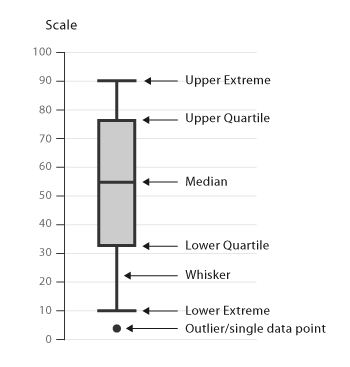

### Boxplot of each attribute intrepts
that some columns have too much outliers in them, hence it can be a factor affecting the overall model bias
model is learning from outliers \ <br>
[Outliers Handling](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)

In [ ]:
from numpy import percentile
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
#identifying outliers
h_means = housing_num.mean(axis=0)
h_std = housing_num.std(axis=0)

In [ ]:
#way 1: to get 25%, 75% percentile
IQR_housing_dict = {}
for i in housing_num.columns:
    data = housing_num.loc[:, i].values
    q25 = percentile(data, 25)
    q75 = percentile(data, 75)
    IQR_housing_dict[i] = [q25, q75]
IQR_housing_dict

In [ ]:
# way 2: to get IQR cutoff
Qtr = housing_num.describe().loc[('25%','75%'),:].T
Qtr['cutoff'] = (Qtr['75%'] - Qtr['25%'])*1.5
Qtr['lower'] = Qtr['25%'] - Qtr['cutoff']
Qtr['upper'] = Qtr['75%'] + Qtr['cutoff']
Qtr

In [ ]:
#outliers in each attributes
print("Outliers")
for i in housing_num:
    outliers = [x for x in housing_num[i] if x < Qtr.loc[(i), 'lower'] or x > Qtr.loc[(i), 'upper']]
    print(i,": ", len(outliers))

### Local Outlier Factor

In [ ]:
#this is neccessary as lof can't handle missing values
impute = SimpleImputer(strategy='mean')
data = impute.fit_transform(housing_num)

lof = LocalOutlierFactor()
yhat = lof.fit_predict(data)
yhat.size

In [ ]:
#removing outliers
mask = yhat != -1
data, y_labels = housing.loc[mask, :], housing_labels[mask]
print(data.shape, y_labels.shape)

In [ ]:
# putting this cleaned data into pipeline
# training the models with removed outlier data
pipe.fit(data, y_labels)
pipe_svr.fit(data, y_labels)

#prediction on housing
y_pred_lr = pipe.predict(data)
y_pred_svr = pipe_svr.predict(data)

#results
print("linear score: ", rs(y_labels, y_pred_lr))
print("svr score: ", pipe_svr.score(data, y_pred_svr))

In [ ]:
 def plot(axes, y_pred, labels, title):
    sb.regplot(y=y_pred,x= labels, ci=None, color="red", ax=axes,
               scatter_kws={"color":"blue",'s':1,'alpha':0.4}, label='points')

    axes.plot(y_pred[y_pred > 0], y_pred[y_pred > 0], 'yellow', alpha=0.5, label='model line')
    axes.set_title(title)
    axes.set_xlabel("actual labels")
    axes.set_ylabel("predicted")
    axes.legend()

fig, ax = plt.subplots(2,1, figsize=(16,12))
plot(ax[0], y_pred_lr, y_labels, title="Linear Regression")
plot(ax[1], y_pred_svr, y_labels, title="SVR")
plt.show()

In [ ]:
# A test Case
X = housing.iloc[45,:]
y = housing_labels.loc[45]

y_test_lr = pipe.predict(X.to_frame().T)
y_test_svr = pipe_svr.predict(X.to_frame().T)

print("Original: ", y)
print(f"LR: {y_test_lr}\nSVR: {y_test_svr}")